In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from numpy.linalg import lstsq
import os
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os, re
from poppy.zernike import zernike_basis,decompose_opd

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)


<span style="color:green; font-size: 2.5em;">Functions</span>


In [50]:
##########################################################################
##########################################################################
def parse_beam_center(fn):
    bx = by = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Beam Center X [mm]' in L:
                bx = float(L.split(',')[1])
            elif 'Beam Center Y [mm]' in L:
                by = float(L.split(',')[1])
            if bx is not None and by is not None:
                break
    if bx is None or by is None:
        raise RuntimeError("Beam center not found")
    return bx, by
##########################################################################
##########################################################################
def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan) 
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue 
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)  
        y_coords.append(y)
        wavefront_data.append(vals)
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)
    print(f"x_coords length: {len(x_coords)}")
    print(f"wavefront_data shape: {wf_array.shape}")
    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")
    return x_coords, y_coords, wf_array
##########################################################################
##########################################################################
def parse_zernike_coeffs(fn, n_modes):
    coeffs = []
    in_z = False
    pat = re.compile(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)')
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if L.strip().startswith('*** ZERNIKE FIT ***'):
                in_z = True
                continue
            if in_z:
                m = pat.match(L)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    return np.array(coeffs)
##########################################################################
##########################################################################
def noll_to_zernike(j):
    n = 0; j1 = j - 1
    while j1 >= n+1:
        n += 1; j1 -= n
    m = -n + 2*j1
    return n, m
##########################################################################
##########################################################################
def remap_sensor_coeffs(raw, n_modes):
    rem = np.zeros(n_modes)
    for i, c in enumerate(raw, start=1):
        tgt = {2:3, 3:2}.get(i, i)
        if tgt <= n_modes:
            rem[tgt-1] = c
    return rem
##########################################################################
##########################################################################
def parse_pupil_diameter(fn):
    pd = None
    pcx = None
    pcy = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Pupil Diameter X [mm]' in L:
                pd = float(L.split(',')[1])
            elif 'Pupil Center X [mm]' in L:
                pcx = float(L.split(',')[1])
            elif 'Pupil Center Y [mm]' in L:
                pcy = float(L.split(',')[1])
    if pd is None or pcx is None or pcy is None:
        raise RuntimeError("Pupil diameter or center not found")
    return pd, pcx, pcy
##########################################################################
##########################################################################
def crop_to_square(arr):
    ny, nx = arr.shape
    size = min(ny, nx)
    startx = (nx - size) // 2
    starty = (ny - size) // 2
    return arr[starty:starty + size, startx:startx + size]
##########################################################################
##########################################################################



<span style="color:blue; font-size: 2.5em;">Grafici </span>

In [51]:
def plot_wavefront(x_coords, y_coords, wf_array, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(wf_array, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()),
                   origin='upper', cmap='jet', aspect='auto')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    if title:
        ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Wavefront Error [nm]')
    plt.show()

<span style="color:yellow; font-size: 2.5em;">Variabili in input </span>

In [43]:


file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
directory = r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus"
filenumber = 9 # sceglie il file specifico nella cartella directory
pupil_diameter = 5.8  # mm
nterms        = 15
pixel_scale = 0.150  # mm/pixel SPAZIATURE DEGLI SPOT NEL PIANO, NON LA REALE DIMENSIONE DEI PIXEL (QUELLA è 5.86 micron)



<span style="color:orange; font-size: 2.5em;">Codice </span>

x_coords length: 74
wavefront_data shape: (45, 74)
Pupil radius in pixels: 19.333333333333332
Pupil center in pixels: (36, -22)


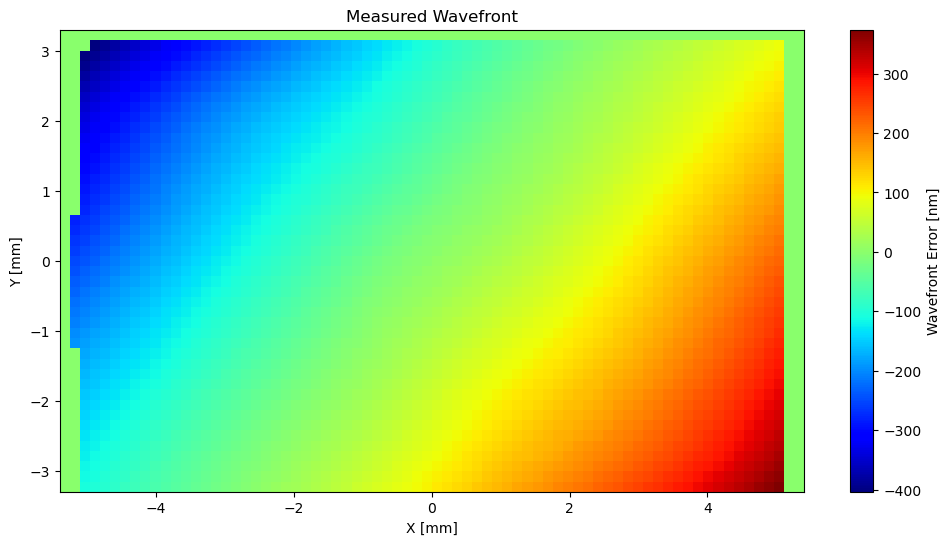

ValueError: operands could not be broadcast together with shapes (45,74) (45,45) 

In [52]:

from sklearn.metrics import mean_squared_error

files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError("No CSV files found in directory")
filename = files[filenumber]
full_path = os.path.join(directory, filename)
file = full_path  

x, y, wavefront = parse_wavefront_grid(file)
# Filter out NaN values
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
wavefront = np.nan_to_num(wavefront, nan=0.0)


# 1. Parse pupil diameter and center
pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter(file)

# 2. Convert pupil diameter and center from mm to pixels

pupil_radius_pix = (pupil_diameter / 2) / pixel_scale
x_center_pix = (pupil_center_x - x[0]) / pixel_scale
y_center_pix = (pupil_center_y - y[0]) / pixel_scale
x_center_pix = int(x_center_pix)
y_center_pix = int(y_center_pix)
print(f"Pupil radius in pixels: {pupil_radius_pix}")
print(f"Pupil center in pixels: ({x_center_pix}, {y_center_pix})")

# 3. Apply circular mask to the wavefront data
wf_masked = np.copy(wavefront)


# 4. Create mask based on actual center/radius
yy, xx = np.indices(wavefront.shape)
r = np.sqrt((xx - x_center_pix)**2 + (yy - y_center_pix)**2)
mask = r <= pupil_radius_pix


plot_wavefront(x, y, wavefront, title='Measured Wavefront')

# Perform Zernike fitting
zernike_coeffs = decompose_opd(wf_masked, mask=mask, nterms=nterms)

# Generate Zernike map
zernike_map = zernike_basis(nterms, wf_masked.shape, outside=np.nan, mask=mask).dot(zernike_coeffs)

# Calculate the difference between the measured wavefront and the Zernike fit
difference = wavefront - zernike_map

# Plot the Zernike map
plot_wavefront(x, y, zernike_map, title='Zernike Fit')

# Plot the difference
plot_wavefront(x, y, difference, title='Difference (Measured - Zernike Fit)')


<span style="color:Green; font-size: 2.5em;">Beta </span>

x_coords length: 74
wavefront_data shape: (45, 74)
Mode 1: -3.043288 
Mode 2: 53.060103 
Mode 3: -44.960798 
Mode 4: -0.782693 
Mode 5: -0.078643 
Mode 6: -1.238577 
Mode 7: -0.195944 
Mode 8: 1.661367 
Mode 9: -0.265064 
Mode 10: -1.485088 
Mode 11: 0.527787 
Mode 12: 0.226109 
Mode 13: 0.005459 
Mode 14: -0.205431 
Mode 15: -0.124503 


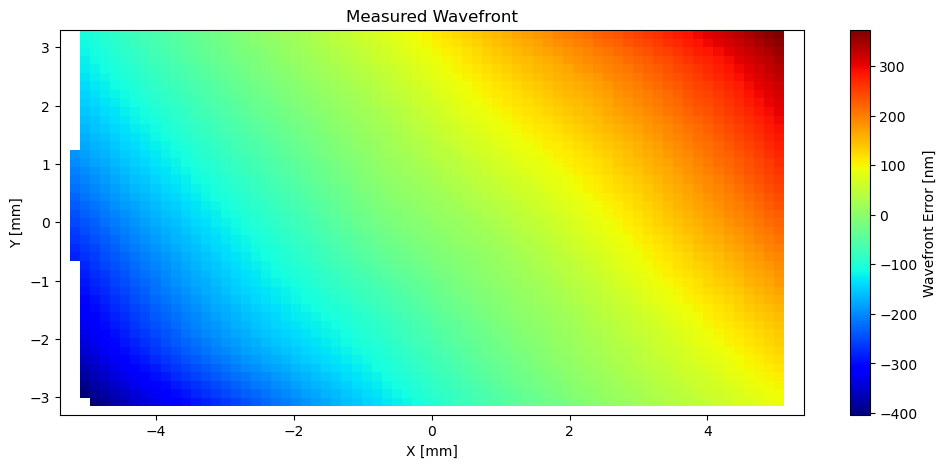

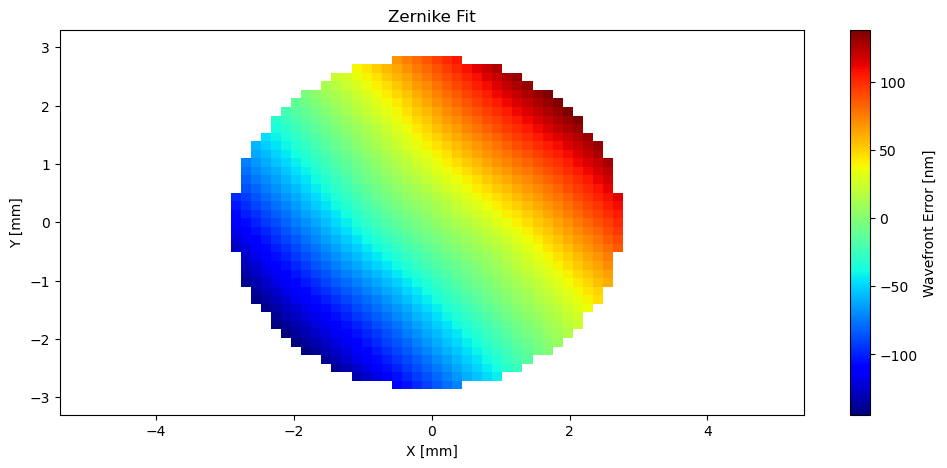

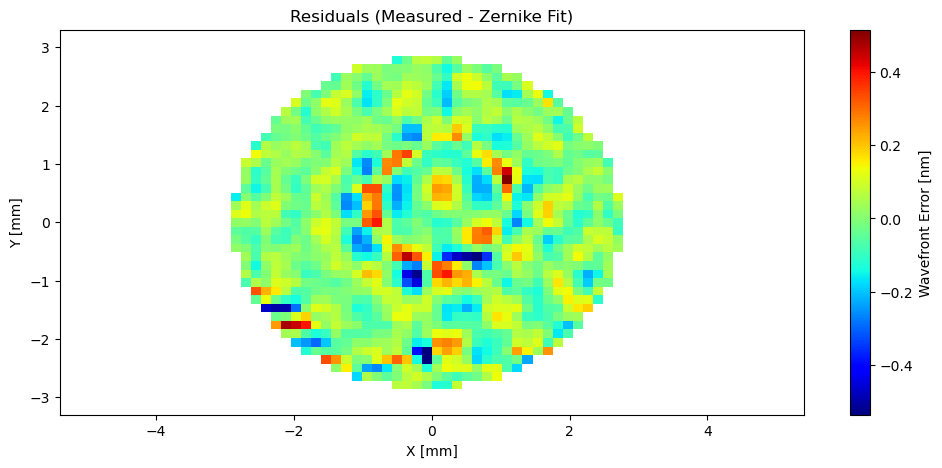

In [62]:
def fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode):  # maxmode=15
    # Normalize to unit pupil centered at 
    X_norm = x_coords / (pupil_diameter / 2)
    Y_norm = y_coords / (pupil_diameter / 2)

    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)

    mask = R <= 1
    wf_masked = wavefront_data[mask]


    basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)

    Z_mat = np.vstack([basis_stack[j][mask] for j in range(max_mode)]).T

    # Fit coefficients with least squares
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wf_masked, rcond=None)

    # fitted wavefront
    wf_fit = np.full_like(wavefront_data, np.nan)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(max_mode)], axis=0)
    wf_fit[mask] = fit_vals

    return coeffs, wf_fit



def plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit):
    extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(wavefront_data, extent=extent, origin='upper', cmap='jet')
    axs[0].set_title('Measured Wavefront')
    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    plt.colorbar(im0, ax=axs[0], label='[μm]')

    im1 = axs[1].imshow(wavefront_fit, extent=extent, origin='upper', cmap='jet')
    axs[1].set_title('Reconstructed fitted Wavefront')
    axs[1].set_xlabel('X [mm]')
    axs[1].set_ylabel('Y [mm]')
    plt.colorbar(im1, ax=axs[1], label=' [μm]')

    plt.tight_layout()
    plt.show()




from sklearn.metrics import mean_squared_error


files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError("No CSV files found in directory")
filename = files[filenumber]
full_path = os.path.join(directory, filename)
file = full_path  

##### Lettura dati ########################à
x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter(file)
coeffs, wavefront_fit = fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, nterms)
for i, c in enumerate(coeffs, 1):
    print(f"Mode {i}: {c:.6f} ")#µm")

#plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit)


#  Zernike modes (n=6)
orders = 15
# Number of Zernike modes up to n=6: (n+1)(n+2)/2 = 28
n_modes = (orders + 1) * (orders + 2) // 2
X_norm = x_coords / (pupil_diameter / 2)
Y_norm = y_coords / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1

basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)

# Refit the wavefront using the calculated Zernike basis
Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)

# Create the fitted wavefront
wavefront_fit_2 = np.full_like(wavefront_data, np.nan)
fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
wavefront_fit_2[mask] = fit_vals

# Calculate residuals
residuals = wavefront_data - wavefront_fit_2

# Plotting function
def plot_wavefront_new(x_coords, y_coords, wf_array, title=None, cmap='jet'):
    # Filter out NaN values
    x_coords_valid = x_coords[~np.isnan(x_coords)]
    y_coords_valid = y_coords[~np.isnan(y_coords)]

    plt.figure(figsize=(12, 5))
    plt.imshow(wf_array, extent=(x_coords_valid.min(), x_coords_valid.max(), y_coords_valid.min(), y_coords_valid.max()),
               origin='lower', cmap=cmap, aspect='auto')
    plt.xlabel('X [mm]')
    plt.ylabel('Y [mm]')
    if title:
        plt.title(title)
    plt.colorbar(label='Wavefront Error [nm]')
    plt.show()

# Plot the measured wavefront
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, title='Measured Wavefront')

# Plot the Zernike fit
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_fit_2, title='Zernike Fit')

# Plot the residuals
plot_wavefront_new(x_coords, y_coords, residuals, title='Residuals (Measured - Zernike Fit)')



